# Week 5 Assignment: Filling Missing Frames in MoCap Data using Machine Learning

## Objective
In this assignment, our goal is to restore missing or corrupted frames in Motion Capture (MoCap) sequences using a machine learning model. We treat this as a supervised learning problem, where the model learns to infer a missing frame based on its surrounding context.

## Task Description
Motion Capture data consists of sequences of human joint positions represented as coordinates (typically in 2D or 3D space). In real-world scenarios, some frames may be corrupted or lost due to noise, occlusion, or sensor issues. Our task is to:

- Simulate frame corruption by removing the middle frame in a 7-frame sequence.
- Train a neural network to predict the missing (middle) frame using the 3 frames before and after it as input.

## Approach
- For a given joint, we take 7 consecutive frames.
- The input to the model is made up of the coordinates from 3 frames before and 3 frames after (i.e., 6 frames total).
- The target (label) is the middle frame (the 4th frame in the sequence), which is considered as corrupted/missing.

By using this sliding window technique, we create training samples that simulate missing data, allowing the model to learn a meaningful way to reconstruct frames based on temporal continuity.


## Step 1: Load Dataset

We begin by loading the 2D pose estimation dataset from the [VideoPose3D GitHub repository](https://github.com/facebookresearch/VideoPose3D). This dataset provides human motion data in the form of 2D joint coordinates across video frames.

For this assignment, we will work specifically with the **2D keypoints** to train our machine learning model that predicts and fills corrupted frames. The dataset consists of sequences of joint positions over time and is stored in `.npz` format.


In [3]:
import os
import urllib.request
import subprocess

import warnings
warnings.filterwarnings("ignore")
# This script checks if the VideoPose3D repository exists locally on your PC, clones it if not,
# it downloads our dataset called Human3.6M if it is not already present.

if not os.path.exists("VideoPose3D"):
    subprocess.run(["git", "clone", "https://github.com/facebookresearch/VideoPose3D.git"])

# Download dataset if not exists
data_path = "VideoPose3D/data/data_2d_h36m_cpn_ft_h36m_dbb.npz"
os.makedirs(os.path.dirname(data_path), exist_ok=True)

if not os.path.exists(data_path):
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/video-pose-3d/data_2d_h36m_cpn_ft_h36m_dbb.npz",
        data_path
    )
    print("Dataset downloaded.")
else:
    print("Dataset already exists. You can start using it directly.")


Dataset already exists. You can start using it directly.


## Importing data by path and then
#### Inspecting `metadata` dictionary and `position` dictionary

In [5]:
import numpy as np
# Load dataset
data = np.load(data_path, allow_pickle=True) # allow_pickle=True allows loading of objects stored in the file, such as dictionaries or lists.
print(data.files)  # List all available files in the dataset

metadata = data['metadata'].item()
print(type(metadata))
print(metadata.keys())

positions = data['positions_2d'].item()

print(type(positions))  # type of positions is a dictionary
print(len(positions))   # number of subjects in the dataset
print("Subjects:", list(positions.keys()))             # number of people's motion in the dataset
print("Actions for S7:", list(positions['S7'].keys())) # Inspect actions for subject S2(one person)
print("Shape of S7 - Walking 1 - Cam 0:", positions['S7']['Walking 1'][0].shape) # Inspect shape of keypoints for a specific action and camera

['positions_2d', 'metadata']
<class 'dict'>
dict_keys(['layout_name', 'num_joints', 'keypoints_symmetry'])
<class 'dict'>
10
Subjects: ['S6', 'S7', 'S5', 'S11', 'S1', 'S9', 'S8', 'S2', 'S3', 'S4']
Actions for S7: ['Directions 1', 'Discussion 1', 'Eating 1', 'Greeting 1', 'Phoning 2', 'Posing 1', 'Purchases 1', 'Sitting 1', 'SittingDown', 'Smoking 1', 'Photo', 'Waiting 1', 'Walking 1', 'WalkDog 1', 'WalkTogether 1', 'Directions', 'Discussion', 'Eating', 'Greeting', 'Phoning', 'Posing', 'Purchases', 'Sitting', 'SittingDown 1', 'Smoking', 'Photo 1', 'Waiting 2', 'Walking 2', 'WalkDog', 'WalkTogether']
Shape of S7 - Walking 1 - Cam 0: (3637, 17, 2)


## Step 2: Select Specific Action Data

From the loaded dataset, we choose a specific subject and action for our model training and evaluation. In particular, we select:

- Subject: **S7**
- Action: **Walking 1**
- Camera Angle: **0**

This provides us with a sequence of human motion data having the shape:

**(3637, 17, 2)**

This shape indicates:
- 3637 frames (time steps)
- 17 joints per frame
- Each joint is represented by its (x, y) coordinates

To prepare the data for training with a machine learning model—particularly an LSTM, which expects 2D inputs—we reshape the data to **(3637, 34)** by flattening each frame. This combines all joint coordinates in a single vector per frame:  
**17 joints × 2 coordinates = 34 features per frame**


In [7]:
## defining subject and action

subject = 'S7' # Subject S7 is one of the subjects in the dataset, can change to any other subject like S1, S2, etc.
action = 'Walking 1' # Action 'Walking 1' is one of the actions performed by the subject, can change to any other action like 'Eating', 'Smoking', etc.

keypoints_all = positions[subject][action][0]  # Camera view 0 (4 cameras available: 0,1,2,3)
# keypoints_all is a numpy array of shape (n_frames, 17, 2) where n_frames is the number of frames in the video, 17 is the number of joints, and 2 represents x and y coordinates of each joint.

keypoints_old = positions[subject][action][0]

## data is copied in two variables to use

print(keypoints_all.shape)

keypoints_reshaped = keypoints_all.reshape(-1, 34)
print(keypoints_reshaped.shape)

(3637, 17, 2)
(3637, 34)


## Step 3: Normalize the Data

To help the LSTM model learn more efficiently, we normalize all coordinate values using `MinMaxScaler`.

Normalization scales the data to a fixed range, typically between 0 and 1, which benefits gradient-based learning algorithms like LSTM by:

- Accelerating convergence during training
- Preventing features with larger scales from dominating others
- Improving numerical stability

Since our data consists of (x, y) joint coordinates flattened into 34 features per frame, we apply the scaler across the entire dataset of shape (3637, 34).


In [9]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

def normalize_keypoints_center_scale(keypoints_all):
    num_frames, num_joints, _ = keypoints_all.shape

    # Computing mean per frame (shape: num_frames x 1 x 2)
    means = keypoints_all.mean(axis=1, keepdims=True)

    # Centering data by subtracting mean (shift origin to mean joint position)
    centered = keypoints_all - means  # shape (num_frames, 17, 2)

    # Flattening for scaling
    flat_centered = centered.reshape(-1, 2)

    # Fitting scalers on centered data
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    x_scaled = scaler_x.fit_transform(flat_centered[:, 0].reshape(-1, 1)).flatten()
    y_scaled = scaler_y.fit_transform(flat_centered[:, 1].reshape(-1, 1)).flatten()

    scaled_flat = np.stack([x_scaled, y_scaled], axis=1)
    keypoints_normalized = scaled_flat.reshape(num_frames, num_joints, 2)

    return keypoints_normalized, means, scaler_x, scaler_y

# Applying normalization
keypoints_normalized, means, scaler_x, scaler_y = normalize_keypoints_center_scale(keypoints_all)


## Step 4: Identify Missing or Corrupted Frames

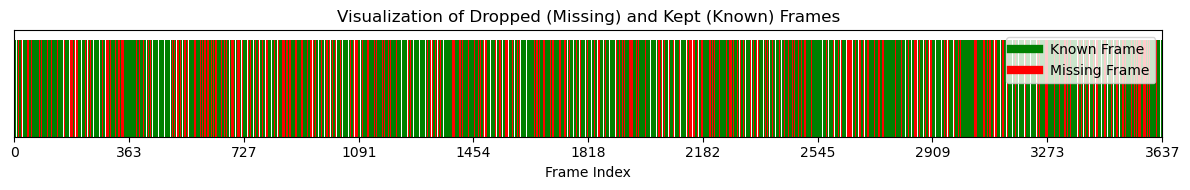

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.42it/s]


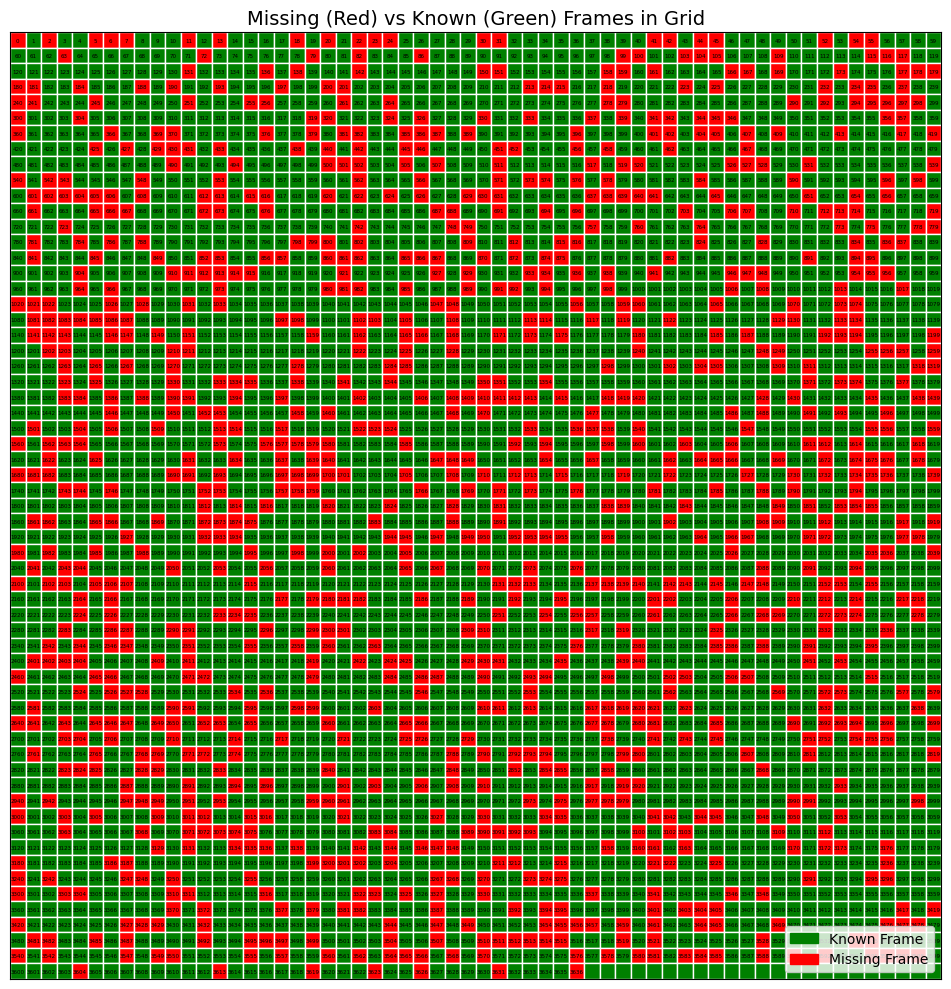

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as mpatches

segment_len = 3637  # Total frames in our data
rng = np.random.default_rng(42)
mask = rng.choice([1, 0], size=segment_len, p=[0.7, 0.3])  # 70% known, 30% missing

# --- Bar plot of known/missing frames ---
fig, ax = plt.subplots(figsize=(12, 2))
for i in range(segment_len):
    color = 'green' if mask[i] == 1 else 'red'
    ax.bar(i, 1, color=color, edgecolor='none', width=0.9, align='center')

ax.set_xlim(0, segment_len)
ax.set_ylim(0, 1.1)
ax.set_xticks(np.linspace(0, segment_len, 11).astype(int))
ax.set_yticks([])
ax.set_xlabel('Frame Index')
ax.set_title('Visualization of Dropped (Missing) and Kept (Known) Frames')

legend_elements = [
    plt.Line2D([0], [0], color='green', lw=6, label='Known Frame'),
    plt.Line2D([0], [0], color='red', lw=6, label='Missing Frame')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

# --- Grid plot ---
# Choose grid size close to sqrt(segment_len)
import math
rows = 61
cols = 60
assert rows * cols >= segment_len, "Grid size must cover all frames"

if rows * cols > segment_len:
    pad_len = rows * cols - segment_len
    mask_padded = np.concatenate([mask, np.ones(pad_len, dtype=int)])  # padding with known frames for visualization
else:
    mask_padded = mask

mask_grid = mask_padded.reshape((rows, cols))

fig, ax = plt.subplots(figsize=(40, 10))
cmap = {0: 'red', 1: 'green'}

for r in tqdm(range(rows)): # we only plotted the first 200 frames during week-04, now we plot all frames, the representation is kind of messy, try to plot it in a better way
    for c in range(cols):
        color = cmap[mask_grid[r, c]]
        rect = plt.Rectangle((c, rows - 1 - r), 1, 1, facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        frame_idx = r * cols + c
        if frame_idx < segment_len:
            ax.text(c + 0.5, rows - 1 - r + 0.5, str(frame_idx),
                    color='black', ha='center', va='center', fontsize=4)

ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Missing (Red) vs Known (Green) Frames in Grid", fontsize=14)

green_patch = mpatches.Patch(color='green', label='Known Frame')
red_patch = mpatches.Patch(color='red', label='Missing Frame')
ax.legend(handles=[green_patch, red_patch], loc='lower right')

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


## Step 5: Generate Training Datasets

To train our model, we need a large number of (input, target) pairs that simulate the missing-frame scenario. For this, we use the custom class `MocapDataGenerator3D`, which automates the dataset creation process.

The idea is to extract all valid sequences of **7 consecutive known (non-missing) frames** from the normalized MoCap data. For each such sequence:

- The **input** consists of 6 frames: 3 before and 3 after the middle frame.
- The **target/output** is the **middle (4th) frame**, which we aim to predict.

This sliding-window technique ensures:
- Temporal continuity is maintained
- The model learns how to interpolate or reconstruct the center frame from its context

The resulting training inputs have shape `(num_samples, 6, 34)` and targets have shape `(num_samples, 34)`.
amples, 34)`.


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

# Parameters
window_size = 7  
num_joints = 17
coord_dim = 2
input_dim = num_joints * coord_dim # 34
hidden_dim = 256
batch_size = 32
epochs = 100 # Try to implement early stopping

# The below class is sourced from the VideoPose3D repository, it is a helper class to generate batches of data for training.
class MocapDataGenerator3D(Sequence):
    def __init__(self, keypoints, mask, window_size, batch_size=32):
        self.keypoints = keypoints
        self.mask = mask
        self.window_size = window_size
        self.batch_size = batch_size

        half_w = window_size // 2
        self.indices = [
            i for i in range(half_w, len(keypoints) - half_w)
            if mask[i] == 1
        ]

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []
        half_w = self.window_size // 2
        for center in batch_indices:
            start = center - half_w
            end = center + half_w + 1
            past = self.keypoints[start:center]
            future = self.keypoints[center+1:end]
            window = np.vstack((past, future))
            X.append(window.reshape(6, -1))
            y.append(self.keypoints[center].reshape(-1))
        return np.array(X), np.array(y)

train_gen = MocapDataGenerator3D(keypoints_normalized, mask, window_size=window_size, batch_size=batch_size)


## Step 6: Model Overview – LSTM-Based Frame Predictor

To effectively capture temporal patterns in MoCap sequences, we use an **LSTM (Long Short-Term Memory)** network. LSTMs are a type of recurrent neural network (RNN) designed to model sequential data while retaining long-term dependencies.

In our case, the model takes as input 6 consecutive frames (3 before and 3 after the missing frame). Since human motion is inherently sequential and continuous, LSTMs are well-suited for learning how the joints move over time and how to interpolate between frames.

### Model Architecture Overview:
- **Input**: A sequence of 6 frames, each containing 34 features (flattened joint coordinates).
- **LSTM Layers**: Two stacked LSTM layers process the temporal information. The first returns the full sequence, while the second summarizes it into a fixed-size representation.
- **Dense Layers**: Fully connected layers refine this representation and map it to the target output.
- **Output**: A vector of 34 values, representing the reconstructed coordinates of the middle frame.

This architecture allows the model to learn meaningful temporal relationships and make accurate frame-level predictions.


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_model(window_size, input_dim, hidden_dim):
    inputs = Input(shape=(6, input_dim))  # input is 6 frames 

    # Single-direction LSTM layers
    x = LSTM(hidden_dim, return_sequences=True)(inputs)  # First LSTM layer with sequence output
    x = LSTM(hidden_dim)(x)                              # Second LSTM layer with final output only

    # Fully connected layers
    x = Dense(hidden_dim * 2, activation='relu')(x)
    x = Dense(hidden_dim, activation='relu')(x)

    # Final output layer (predicting the middle frame's 34 values)
    outputs = Dense(input_dim, activation='linear')(x)

    return Model(inputs, outputs)


## Step 7: Model Compilation and Training

After defining the LSTM-based model, we compile it using the **Mean Squared Error (MSE)** loss function, which is suitable for regression tasks involving continuous output values like joint coordinates.

We use the **Adam optimizer** with a learning rate of `1e-3` for efficient and adaptive learning.

The model is trained using the generated dataset, and we include an **EarlyStopping** callback to prevent overfitting. This stops training if the validation loss doesn't improve for several epochs and restores the best weights.

Finally, we view the model summary to verify the architecture before training.


In [17]:
model = build_lstm_model(window_size, input_dim, hidden_dim)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse'
)

model.summary()

model.fit(
    train_gen,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 6, 34)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 6, 256)              │         297,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 34)                  │           8,738 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,094,946 (4.18 MB)

 Trainable params: 1,094,946 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0501
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0064
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0075
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0028
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0019
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0038
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0016
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0016
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0012
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0020
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0021
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0012
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0013
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0013
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - l

#### Defining function to take inverse of output

In [19]:
def inverse_transform_reconstructed(pred_norm, means, scaler_x, scaler_y, frame_idx):
    # Step 1: Inverting scale (normalized [0,1] -> centered coordinates)
    x_norm = pred_norm[:, 0].reshape(-1, 1)
    y_norm = pred_norm[:, 1].reshape(-1, 1)

    x_centered = scaler_x.inverse_transform(x_norm).flatten()
    y_centered = scaler_y.inverse_transform(y_norm).flatten()

    pred_centered = np.stack([x_centered, y_centered], axis=1)

    # Step 2: Adding back the mean (centered -> original coordinates)
    pred_original = pred_centered + means[frame_idx].reshape(1, 2)

    return pred_original

## Step 8: Predict Missing Frames

In [21]:
keypoints_reconstructed = keypoints_all.copy()  # Start with the full original sequence

# Iterate through all frames where a full window is available
for i in tqdm(range(window_size // 2, len(mask) - window_size // 2)):

    if mask[i] == 0:  # If the current frame is missing (needs reconstruction)
        # Extract the surrounding window of frames centered at frame i
        window_past = keypoints_reconstructed[i - window_size // 2 : i] ## 3 frames before
        window_future = keypoints_reconstructed[i + 1 : i + window_size // 2 + 1]  ## 3 rames after

        window = np.vstack((window_past , window_future)) ## constructing input of (6,34)

        # Normalize each frame in the window (mean-centering and scaling)
        window_scaled = []
        for frame in window:
            frame_centered = frame - frame.mean(axis=0, keepdims=True)
            x_scaled = scaler_x.transform(frame_centered[:, 0].reshape(-1, 1)).flatten()
            y_scaled = scaler_y.transform(frame_centered[:, 1].reshape(-1, 1)).flatten()
            window_scaled.append(np.stack([x_scaled, y_scaled], axis=1))

        # Convert to array and reshape to match model input shape
        window_input = np.array(window_scaled).reshape(1, 6, 34)

        # Predict the missing (center) frame
        pred_norm = model.predict(window_input, verbose=0)[0].reshape(num_joints, coord_dim)

        # Inverse normalization to return to original coordinate space
        pred_original = inverse_transform_reconstructed(pred_norm, means, scaler_x, scaler_y, i)

        # Save the reconstructed frame
        keypoints_reconstructed[i] = pred_original

    else:
        # If frame is not missing, retain the original
        keypoints_reconstructed[i] = keypoints_all[i]

print("Reconstruction completed!")


100%|██████████████████████████████████████████████████████████████████████████████| 3631/3631 [03:53<00:00, 15.53it/s]

Reconstruction completed!


In [22]:
# Debuging: check scale
print(f"Original data range: x[{keypoints_all[:,:,0].min():.1f}, {keypoints_all[:,:,0].max():.1f}], y[{keypoints_all[:,:,1].min():.1f}, {keypoints_all[:,:,1].max():.1f}]")
print(f"Reconstructed data range: x[{keypoints_reconstructed[:,:,0].min():.1f}, {keypoints_reconstructed[:,:,0].max():.1f}], y[{keypoints_reconstructed[:,:,1].min():.1f}, {keypoints_reconstructed[:,:,1].max():.1f}]")

Original data range: x[148.2, 821.2], y[284.0, 804.3]
Reconstructed data range: x[148.2, 826.0], y[280.8, 804.3]


## Step 9: Error Calculation

We compute the Mean Squared Error (MSE) between each predicted and actual missing frame, then take the average across all missing frames to get the final reconstruction error.


In [24]:
mse_list = []

for frame_idx in range(len(mask)):
    orig = keypoints_all[frame_idx]
    recon = keypoints_reconstructed[frame_idx]
    mse = np.mean((orig - recon) ** 2)
    mse_list.append(mse)

mean_mse = np.mean(mse_list)
print(f"Mean MSE over all reconstructed frames = {mean_mse:.6f}")
print("Note that this MSE is computed over all frames, including both known and missing frames.")

Mean MSE over all reconstructed frames = 11.235202
Note that this MSE is computed over all frames, including both known and missing frames.


## Step 10: Visualize Best and Worst Predictions

To qualitatively evaluate the model’s performance, we identify:

- The **best-predicted frame** (lowest reconstruction error)
- The **worst-predicted frame** (highest reconstruction error)

We then plot the predicted vs. ground truth joint positions for these frames to visually inspect how well the model performs in both ideal and challenging cases.


In [26]:
mse_list = []

for frame_idx in range(3, len(mask) - 3):
    if mask[frame_idx] == 0:
        orig = keypoints_all[frame_idx]
        recon = keypoints_reconstructed[frame_idx]
        mse = np.mean((orig - recon) ** 2)
        mse_list.append((frame_idx, mse))

mse_list_sorted = sorted(mse_list, key=lambda x: x[1])

# Best and worst frames
best_frame_idx, best_mse = mse_list_sorted[0]
worst_frame_idx, worst_mse = mse_list_sorted[-1]

print(f"Best Frame: {best_frame_idx} with MSE = {best_mse:.6f}")
print(f"Worst Frame: {worst_frame_idx} with MSE = {worst_mse:.6f}")

Best Frame: 2050 with MSE = 9.603477
Worst Frame: 1967 with MSE = 273.470825


In [27]:
skeleton_edges = [
    (0, 1),   # Hip -> Right Hip
    (1, 2),   # Right Hip -> Right Knee
    (2, 3),   # Right Knee -> Right Ankle
    (0, 4),   # Hip -> Left Hip
    (4, 5),   # Left Hip -> Left Knee
    (5, 6),   # Left Knee -> Left Ankle
    (0, 7),   # Hip -> Spine
    (7, 8),   # Spine -> Thorax
    (8, 9),   # Thorax -> Neck
    (9, 10),  # Neck -> Head

    (8, 11),  # Thorax -> Left Shoulder
    (11, 12), # Left Shoulder -> Left Elbow
    (12, 13), # Left Elbow -> Left Wrist

    (8, 14),  # Thorax -> Right Shoulder
    (14, 15), # Right Shoulder -> Right Elbow
    (15, 16)  # Right Elbow -> Right Wrist
]

def show_frame(frame_to_show):
    gt = keypoints_old[frame_to_show]             # Ground truth keypoints (17,2)
    recon = keypoints_reconstructed[frame_to_show]  # Reconstructed keypoints (17,2)

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6, 6))

    all_x = np.concatenate([gt[:, 0], recon[:, 0]])
    all_y = np.concatenate([gt[:, 1], recon[:, 1]])
    margin = 50
    ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
    ax.set_ylim(-(all_y.max() + margin), -(all_y.min() - margin))
    ax.set_aspect('equal')

    # Ground-truth (blue)
    ax.scatter(gt[:, 0], -gt[:, 1], c='blue', s=30, label='Ground Truth')
    for i, j in skeleton_edges:
        ax.plot([gt[i, 0], gt[j, 0]], [-gt[i, 1], -gt[j, 1]], 'b-', lw=2)

    # Reconstructed (green)
    ax.scatter(recon[:, 0], -recon[:, 1], c='green', s=30, alpha=0.5, label='Reconstructed')
    for i, j in skeleton_edges:
        ax.plot([recon[i, 0], recon[j, 0]], [-recon[i, 1], -recon[j, 1]], color='green', lw=2, alpha=0.5)

    ax.set_title(f"Frame {frame_to_show} - Ground Truth vs Reconstructed", fontsize=14)
    ax.legend(fontsize=8)
    ax.axis("off")
    plt.show()


Showing frame 2050 (Best Case)


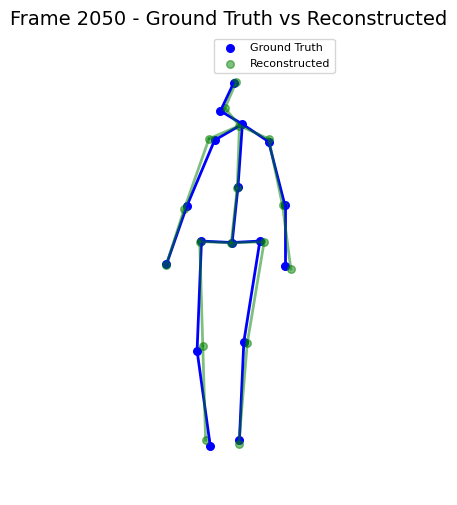

Showing frame 1967 (Worst Case)


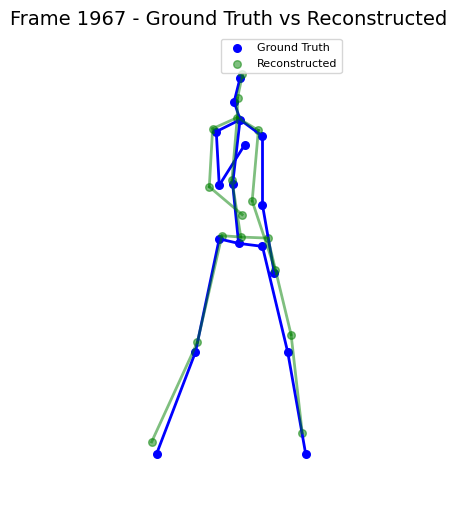

In [28]:
print(f"Showing frame {best_frame_idx} (Best Case)")
show_frame(best_frame_idx)  # Best Case Frame
print(f"Showing frame {worst_frame_idx} (Worst Case)")
show_frame(worst_frame_idx) # Worst Case Frame

## Step 11: Visualize Original and Reconstructed Videos

To better understand the model's impact, we generate and compare two videos:

- The **original video**, showing the MoCap sequence with missing frames
- The **reconstructed video**, where the missing frames have been filled in by the model

This visual comparison helps demonstrate how accurately the model has restored the motion continuity, and whether the reconstructed frames appear natural and consistent with the surrounding motion.


In [30]:
import cv2

def write_skeleton_video(
    keypoints_all,   # shape: (num_frames, 17, 2)
    draw_skeleton_frame_fn,  # function to draw a single frame, yes you can pass a function as an argument to another function
    output_path,
    fps=50,
    width=640,
    height=480,
    start_frame=0,
    frame_count=200
):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for f in tqdm(range(start_frame, start_frame + frame_count)):
        keypoints = keypoints_all[f]
        frame_img = draw_skeleton_frame_fn(keypoints, f)
        video.write(frame_img)

    video.release()
    print('\n',f"Video saved to: {output_path}")

In [31]:
from scipy.ndimage import gaussian_filter1d

def smooth_trajectory(keypoints_2d, sigma=2.0):
    smoothed = np.zeros_like(keypoints_2d) #creates an array of zeros with the same shape as keypoints_2d (num_frames, num_joints, 2)

    # Smoothing each joint and coordinate separately
    for joint in range(keypoints_2d.shape[1]): #here keypoints_2d.shape[1] gives the number of joints, if it were keypoints_2d.shape[0] it would give the number of frames
        for coord in range(2):  # x and y
            smoothed[:, joint, coord] = gaussian_filter1d(
                keypoints_2d[:, joint, coord],
                sigma=sigma,
                mode='nearest'  # Handles edge effects
            )

    return smoothed

In [32]:
width, height = 800, 800  # final video resolution

def draw_skeleton_frame(keypoints, frame_idx=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    x_margin = 50
    y_margin = 50
    x_min, x_max = keypoints[:, 0].min(), keypoints[:, 0].max()
    y_min, y_max = keypoints[:, 1].min(), keypoints[:, 1].max()

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(-(y_max + y_margin), -(y_min - y_margin))
    ax.set_aspect('equal')
    ax.axis('off')

    ax.scatter(keypoints[:, 0], -keypoints[:, 1], c='blue', s=20) # here s is the size of the points
    for i, j in skeleton_edges:
        x = [keypoints[i, 0], keypoints[j, 0]]
        y = [-keypoints[i, 1], -keypoints[j, 1]]
        ax.plot(x, y, 'b-', lw=2)

    if frame_idx is not None:
        ax.set_title(f"Frame {frame_idx}", fontsize=12)

    fig.tight_layout()
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba()) # Converting the canvas to a numpy array
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR) # Converting RGBA to BGR for OpenCV compatibility, RGBA is a color format used by matplotlib, while OpenCV uses BGR.
    img_bgr = cv2.resize(img_bgr, (width, height))
    plt.close(fig)
    return img_bgr # this returns with skeleton drawn on it

In [33]:
sigma = 3  # Increase for more smoothing but dont go too high or observe it if you want
smoothed_keypoints = smooth_trajectory(keypoints_reconstructed, sigma=sigma)
write_skeleton_video(
    smoothed_keypoints,
    draw_skeleton_frame,
    output_path='Week5_smoothed_skeleton_video.mp4',
    fps=50,
    width=800,
    height=800,
    start_frame=70,
    frame_count=1500
)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:54<00:00,  5.10it/s]


 Video saved to: Week5_smoothed_skeleton_video.mp4


In [34]:
sigma = 3  # Increase for more smoothing but dont go too high or observe it if you want
smoothed_keypoints = smooth_trajectory(keypoints_all, sigma=sigma)
write_skeleton_video(
    smoothed_keypoints,
    draw_skeleton_frame,
    output_path='Week5_skeleton_video.mp4',
    fps=50,
    width=800,
    height=800,
    start_frame=70,
    frame_count=1500
)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:55<00:00,  5.08it/s]


 Video saved to: Week5_skeleton_video.mp4


In [35]:
subprocess.run(['start', 'Week5_smoothed_skeleton_video.mp4'], shell=True)

CompletedProcess(args=['start', 'Week5_smoothed_skeleton_video.mp4'], returncode=0)

In [36]:
subprocess.run(['start', 'Week5_skeleton_video.mp4'], shell=True)

CompletedProcess(args=['start', 'Week5_skeleton_video.mp4'], returncode=0)

In [37]:
# Just to compare the original and smoothed videos side by side, we will create a new video that combines both.
width, height = 800, 800
fps = 50  # frames per second
vid1 = cv2.VideoCapture('Week5_skeleton_video.mp4')
vid2 = cv2.VideoCapture('Week5_smoothed_skeleton_video.mp4')

# ------------ Video writer ------------
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('Week5_smooth_compare.mp4', fourcc, fps, (width * 2, height))

while True:
    ret1, frame1 = vid1.read()
    ret2, frame2 = vid2.read()
    if not ret1 or not ret2:
        break
    # Stacking frames horizontally
    combined_frame = cv2.hconcat([frame1, frame2])
    out.write(combined_frame)

vid1.release() # It is necessary to release the video capture objects, it will free up a lot of resources cv2 has used.
vid2.release()
out.release()

In [38]:

subprocess.run(['start', 'Week5_smooth_compare.mp4'], shell=True)

CompletedProcess(args=['start', 'Week5_smooth_compare.mp4'], returncode=0)

## Conclusion

In this assignment, we developed an LSTM-based model to reconstruct missing frames in MoCap data using surrounding temporal context. By leveraging sequences of known frames, the model effectively learned to predict the corrupted middle frames.

Through both quantitative (MSE) and qualitative (visual) evaluations, we observed that the model was capable of restoring motion continuity with reasonable accuracy. This approach highlights the potential of deep learning in handling missing or noisy data in time-series applications like motion capture.


## Thank you